In [72]:
# Stiff Robertson's problem from chemical kinetics as in
# https://archimede.uniba.it/~testset/report/rober.pdf
import numpy as np
import matplotlib.pyplot as plt
import time

a = 0.04
b = 1.0e4
c = 3.0e7

# timestep, Tmax, tolearnce for Newton's solver
h = 1.0e-3
Tmax = 1.0e2 # up to 4.0e10
Nsteps = int(np.ceil(Tmax/h))
tol = 1.0e-14
itermax = 20

# initial condition
y0 = np.array([1.0,0.0,0.0])

# the right-hand side
def func(y): 
    dy = np.zeros(3)
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    return Jac


In [73]:
# DIRK2

def NewtonIterDIRK2(y,h,k,gamma):
    aux = y + h*gamma*k
    F = k - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k - np.linalg.solve(DF,F)

def DIRK2step(y,h):
    gamma = 1.0 - 1.0/np.sqrt(2)
    k1 = func(y)
    for j in range(itermax):
        k1 = NewtonIterDIRK2(y,h,k1,gamma)
        if np.linalg.norm(k1 - func(y + h*gamma*k1)) < tol:
            break
    # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
    # print(j)
    k2 = k1
    y = y + h*(1-gamma)*k1
    for j in range(itermax):
        k2 = NewtonIterDIRK2(y,h,k2,gamma)
        aux = y + h*gamma*k2
        if np.linalg.norm(k2 - func(aux)) < tol:
            break
    # print( np.linalg.norm(k2 - func(aux)))
    # print(j)
    return aux


In [74]:
# solve Robertson's problem

sol = np.zeros((Nsteps+1,3))
t = np.arange(0,(Nsteps+1)*h,h)
sol[0,:] = y0

start_time = time.time()

method_name = "DIRK2"
for j in range(Nsteps): # DIRK2
    sol[j+1,:] = DIRK2step(sol[j,:],h)

end_time = time.time()
t_cpu = end_time - start_time

print(f'method = {method_name:5}, CPUtime = {t_cpu:.6e}')
  

method = DIRK2, CPUtime = 1.869437e+00


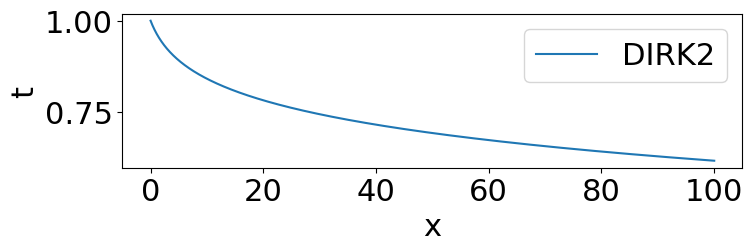

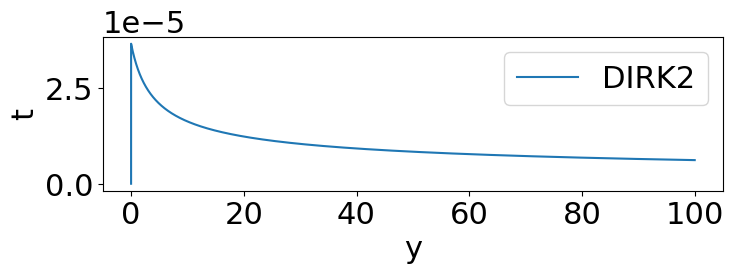

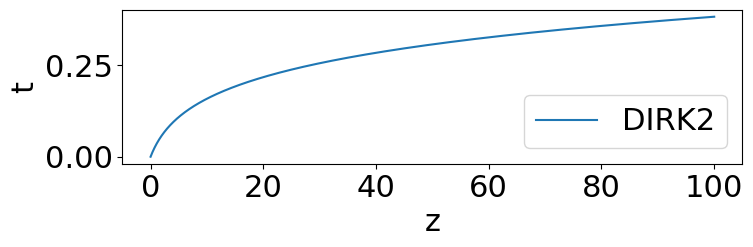

In [75]:
# plot the solution
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,0],label = "DIRK2")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,1],label = "DIRK2")
plt.xlabel("y")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,2],label = "DIRK2")
plt.xlabel("z")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")


Method = DIRK3, CPU time = 3.361325e+00 seconds


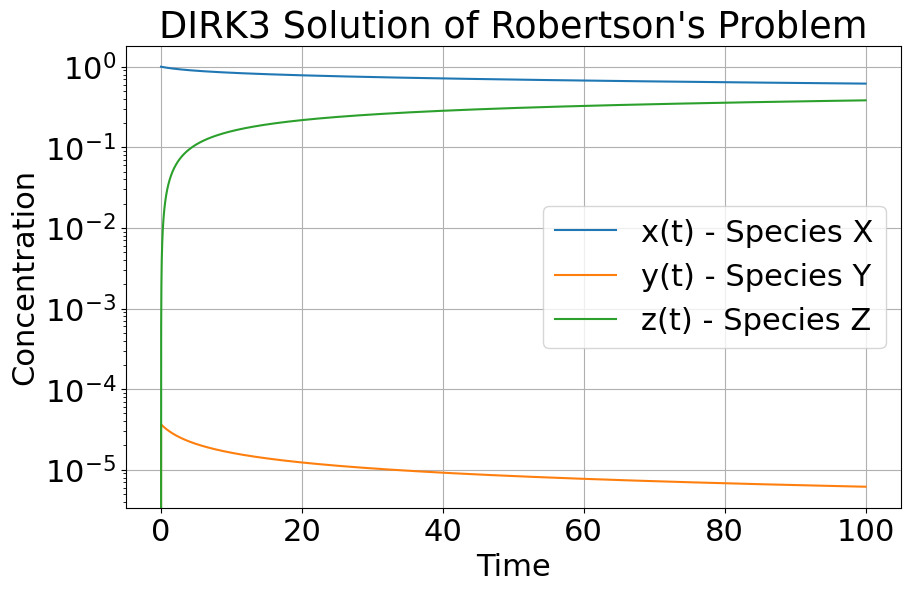

In [76]:
# Newton iteration for DIRK3
def NewtonIterDIRK3(y, h, k, gamma):
    """
    Performs Newton iteration to solve for k in the implicit DIRK3 method.
    """
    aux = y + h * gamma * k  # Predicted next step
    F = k - func(aux)  # Compute the function difference
    DF = np.identity(3) - h * gamma * Jac(aux)  # Compute the Jacobian correction

    return k - np.linalg.solve(DF, F)  # Solve the linear system for k update


def DIRK3step(y, h):
    """
    Performs a single DIRK3 time step.
    """
    gamma = 0.5 + np.sqrt(3) / 6  # γ = 1/2 + sqrt(3)/6
    A = np.array([[gamma, 0], [1 - 2 * gamma, gamma]])  # Butcher tableau coefficients
    b = np.array([0.5, 0.5])  # Final weight for the step

    k1 = func(y)
    for _ in range(itermax):
        k1_new = NewtonIterDIRK3(y, h, k1, gamma)
        if np.linalg.norm(k1_new - k1) < tol:
            break
        k1 = k1_new

    k2 = func(y + h * (1 - 2 * gamma) * k1)
    for _ in range(itermax):
        k2_new = NewtonIterDIRK3(y + h * (1 - 2 * gamma) * k1, h, k2, gamma)
        if np.linalg.norm(k2_new - k2) < tol:
            break
        k2 = k2_new

    return y + h * (b[0] * k1 + b[1] * k2)  # Final update step


sol = np.zeros((Nsteps + 1, 3))
t = np.arange(0, (Nsteps + 1) * h, h)
sol[0, :] = y0

start_time = time.time()

for j in range(Nsteps):  
    sol[j + 1, :] = DIRK3step(sol[j, :], h)

end_time = time.time()
t_cpu = end_time - start_time

print(f'Method = DIRK3, CPU time = {t_cpu:.6e} seconds')


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol[:, 0], label='x(t) - Species X')
plt.plot(t, sol[:, 1], label='y(t) - Species Y')
plt.plot(t, sol[:, 2], label='z(t) - Species Z')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.yscale('log')
plt.legend()
plt.title('DIRK3 Solution of Robertson\'s Problem')
plt.grid()
plt.show()

Method = BDF2, CPU time = 1.657333e+01 seconds


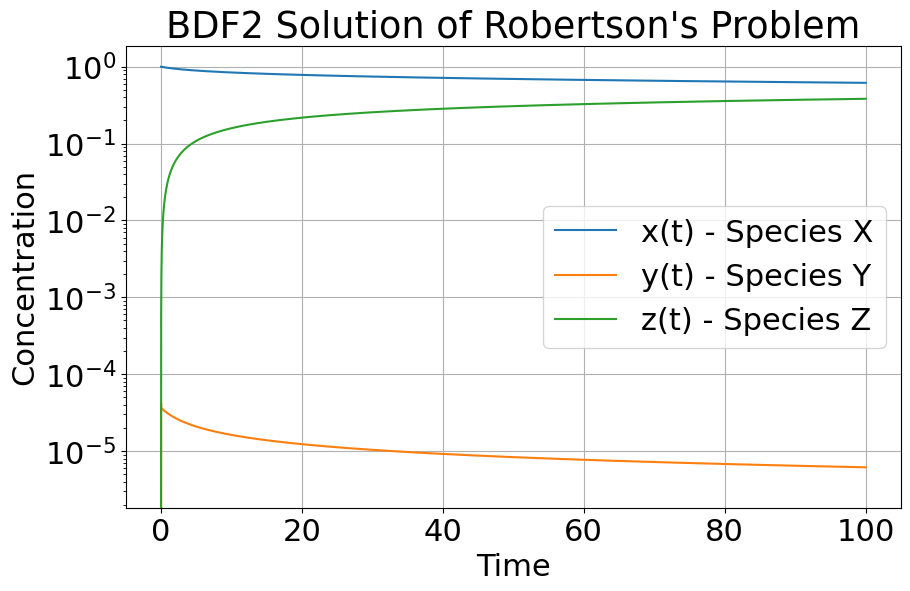

In [ ]:
# Newton iteration for BDF2
def NewtonIterBDF2(y_old, y_older, h):
    """
    Solves for y_new using the BDF2 implicit equation:
    3 y_new - 4 y_old + y_older = 2h * f(y_new)
    """
    y_new = y_old.copy()  # Initial guess
    for _ in range(itermax):
        G = 3 * y_new - 4 * y_old + y_older - 2 * h * func(y_new)
        DF = 3 * np.identity(3) - 2 * h * Jac(y_new)
        delta_y = np.linalg.solve(DF, -G)  # Solve for the correction
        y_new +=delta_y  # Update y_new

        if np.linalg.norm(delta_y) < tol:
            break  # Converged

    return y_new

# DIRK2 step function (for the first step)
def DIRK2step(y, h):
    gamma = 1.0 - 1.0 / np.sqrt(2)
    k1 = func(y)
    for _ in range(itermax):
        k1_new = y + h * gamma * k1
        k1 = func(k1_new)

        if np.linalg.norm(k1_new - k1) < tol:
            break

    y_new = y + h * k1
    return y_new

# Solve using BDF2 (DIRK2 for first step)
sol = np.zeros((Nsteps + 1, 3))
t = np.arange(0, (Nsteps + 1) * h, h)
sol[0, :] = y0

# First step using DIRK2
sol[1, :] = DIRK2step(sol[0, :], h)

# Solve using BDF2 for subsequent steps
start_time = time.time()

for j in range(1, Nsteps):  
    sol[j + 1, :] = NewtonIterBDF2(sol[j, :], sol[j - 1, :], h)

end_time = time.time()
t_cpu = end_time - start_time

print(f'Method = BDF2, CPU time = {t_cpu:.6e} seconds')

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, sol[:, 0], label='x(t) - Species X')
plt.plot(t, sol[:, 1], label='y(t) - Species Y')
plt.plot(t, sol[:, 2], label='z(t) - Species Z')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.yscale('log')
plt.legend()
plt.title('BDF2 Solution of Robertson\'s Problem')
plt.grid()
plt.show()
